<a href="https://colab.research.google.com/github/manojkhara/infectionDetectionDeepLearning/blob/main/VGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# The purpose of this challenge is to develop methods for automatic ocular disease classification.
# With color fundus images from left and right eyes as inputs (may use other provided information, 
# such as patient age, sex),the goal of challenge is to classify patient into eight labels including 
# normal (N), diabetes (D), glaucoma (G), cataract (C), AMD (A), hypertension (H), myopia (M) 
# and other diseases/abnormalities (O) based on both eye images and additionally patient age. 

In [ ]:
# pip install tf-nightly-2.0-preview==2.0.0.dev20191002

In [ ]:
import torch
import torch.nn as nn
from torch.nn import Module
from torch.autograd import Variable
from torch.utils.data import DataLoader,TensorDataset
from torch.optim import lr_scheduler
import torchvision.models as models
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary                                                 # used for printing model used
from tensorflow import summary
# from torch.utils.tensorboard import SummaryWriter

import numpy as np
import scipy.io as sio
import glob
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from PIL import Image 
import cv2 as cv
import csv

import os
from tqdm import tqdm_notebook                                                   # to get % bar of how much percent is left for all epoch to finish while training
import time
import datetime
import itertools

from google.colab import files
from google.colab import drive

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

In [ ]:
# %reload_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/My Drive/trial/Colab-Notebooks/ODIR_dataset

/content/drive/My Drive/trial/Colab-Notebooks/ODIR_dataset


In [ ]:
Train_set_path      = "ODIR-5K_Training_Dataset"
Test_set_path       = "ODIR-5K_Testing_Dataset"
Train_values        = "New_ODIR-5K_Training_Annotations(Updated)_V2.xlsx"
Validate_values     = "New_ODIR-5K_Validation_Annotations(Updated)_V2.xlsx"
# writer = SummaryWriter('runs/ODIR_trial')

Train_set           = os.listdir(Train_set_path)

min column shape = 1444, max column shape = 5184 || min row shape = 893, max row shape = 3456

In [ ]:
class ODIR_train():
    "ophthalmologic image train dataset"

    def __init__(self, xlsx_file, root_dir1, transform=None): 
 
        self.read = pd.read_excel(xlsx_file)
        self.root_dir1 = root_dir1
        self.transform = transform
   
    def __len__(self):
        return len(self.read)

    def name(self,idx):
      img_name_train = self.read.iloc[idx,3]
      return(img_name_train)
    
    def condition_left(self,idx):
      img_condition_train_left = self.read.iloc[idx,5]
      return(img_condition_train_left)

    def condition_right(self,idx):
      img_condition_train_right = self.read.iloc[idx,6]
      return(img_condition_train_right) 

    def __getitem__(self, idx):                              

        img_path_train_left = os.path.join(self.root_dir1,self.read.iloc[idx,3])  # read the name of image from sheet
        sample_train_left   = cv.imread(img_path_train_left)
        img_path_train_right = os.path.join(self.root_dir1, self.read.iloc[idx, 4])
        sample_train_right   = cv.imread(img_path_train_right)

        img_path_label  = self.read.iloc[idx, 7:15]                               # read all the 8 label from sheet
        img_path_label = img_path_label.astype("float")
        sample_label = np.asarray(img_path_label)


        if self.transform:
            sample_train_left = self.transform(sample_train_left)
            sample_train_right = self.transform(sample_train_right)

        return (sample_train_left,sample_train_right, sample_label)


# ************************************************************************************************************
class ODIR_validation():
    "ophthalmologic image train dataset"

    def __init__(self, xlsx_file, root_dir1,  transform=None): 
 
        self.read = pd.read_excel(xlsx_file)
        self.root_dir1 = root_dir1
        self.transform = transform
   
    def __len__(self):
        return len(self.read)

    def name(self,idx):
      img_name_val = self.read.iloc[idx,3]
      return(img_name_val)
    
    def condition_left(self,idx):
      img_condition_val_left = self.read.iloc[idx,5]
      return(img_condition_val_left)

    def condition_right(self,idx):
      img_condition_val_right = self.read.iloc[idx,6]
      return(img_condition_val_right) 

    def __getitem__(self, idx):
        img_path_val_left = os.path.join(self.root_dir1, self.read.iloc[idx, 3])
        sample_val_left   = cv.imread(img_path_val_left)
        img_path_val_right = os.path.join(self.root_dir1, self.read.iloc[idx, 4])
        sample_val_right   = cv.imread(img_path_val_right)

        img_path_label  = self.read.iloc[idx, 7:15]
        img_path_label = img_path_label.astype("float")
        sample_label = np.asarray(img_path_label)
        
        if self.transform:
            sample_val_left = self.transform(sample_val_left)
            sample_val_right = self.transform(sample_val_right)
        return(sample_val_left,sample_val_right,sample_label)


In [ ]:
batch_size_train = 32
batch_size_val = 32

num_epochs = 15
learning_rate = 0.0001
img_width = 224
img_height = 224
n_class = 8

In [ ]:
composed_transform = transforms.Compose([transforms.ToPILImage(),transforms.Resize((299,299)),transforms.ToTensor()])

traindata = ODIR_train( xlsx_file = Train_values,  root_dir1 = Train_set_path,  transform = composed_transform)
trainloader = DataLoader(traindata, batch_size = batch_size_train, shuffle= False ,num_workers=0)

validatedata = ODIR_validation( xlsx_file = Validate_values,  root_dir1 = Train_set_path,  transform = composed_transform)
validateloader = DataLoader(validatedata, batch_size = batch_size_val, shuffle= False ,num_workers=0)


l = len(traindata)
for idx in range (l):
    img = traindata[idx][0]
    label = traindata[idx][1]
    condition = traindata.condition_left(idx)
    #print("image name = ",traindata.name(idx)," | image shape = ",img.shape,"| img condition = ",condition, "| label = ",label)
    img = img.permute(2,1,0)

    #plt.figure(figsize =(8,8))
    #plt.imshow(img)

    if idx ==2:
      break


https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [ ]:
model_conv = models.vgg11_bn(pretrained=False)

for i, param in model_conv.named_parameters():
  param.requires_grad = True

# Since imagenet as 1000 classes , We need to change our last layer according
# to the number of classes we have also  inception has two outputs 1) primary 2) auxillary

# Handle the auxilary net
num_ftrs = model_conv.classifier[6].in_features
model_conv.classifier[6]= nn.Linear(num_ftrs, n_class)
                         
model_conv.cuda()

criterion = nn.BCEWithLogitsLoss().cuda()                                       # Loss and optimizer
optimizer = torch.optim.SGD(model_conv.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

https://medium.com/@iamsdt/using-tensorboard-in-google-colab-with-pytorch-458f9bb95212

https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html


In [ ]:
def metrics(tar,out):
    f = 0
    r = 0
    k = 0
    a = 0
    for i, c in enumerate(zip(out, tar)):
        # # print('i in f1_score: ',i)
        # print('output for f1_score: ',c[0])
        # print(' target for f1_score: ',c[1])

        c[0][c[0] > 0.5] = 1                 # threshold = 0.5
        c[0][c[0] < 0.5] = 0

        out = list(c[0])
        tar = list(c[1])
        # print("after threshold")
        # print("output",out)
        # print("target",tar)
        
        f = f + f1_score(tar, out,average = 'weighted' )
        r = r + roc_auc_score(tar, out )
        k = k + cohen_kappa_score(tar, out )
        a = a + accuracy_score(tar, out)

    f = f / (i + 1)
    r = r / (i + 1)
    k = k / (i + 1)
    a = a / (i + 1)
    
    return(f,k,r,a)


In [ ]:
import torch.nn.functional as F

In [ ]:
training_values = []
validation_values = []
accuracy_train_values =[]
accuracy_val_values =[]

for epoch in tqdm_notebook(range(num_epochs)):
         
    epoch_loss = 0
    f1_add = 0
    accuracy_add = 0
    k_add = 0
    auc_add = 0
    final_score = 0

    for k,train_img in enumerate(trainloader):

        inputs_left,inputs_right,labels = train_img
        #print(inputs_left.shape,inputs_right.shape)
        final = torch.cat((inputs_left,inputs_right),2)
        #print('Image output before interpolation',final.shape)
        final = F.interpolate(final,224)
        final = final.unsqueeze_(0)        
        final = final.reshape(batch_size_train,3,img_width,img_height)

        model_conv.train(mode=True)            

        optimizer.zero_grad()                                                    # zeroes the gradient buffers of all parameters
        #inputs_left = inputs_left.cuda()
        final = final.cuda()
        labels = labels.cuda()
        outputs = model_conv(final)                                  # outputs.shape =(batch_size, n_classes, img_cols, img_rows)

        loss = criterion(outputs, labels.float())                               # loss from primary output

        epoch_loss += loss.item()
        loss.backward()                                                          # Backward and optimizeuns
        optimizer.step()                                                         # update gradients

        labels = labels.cpu().detach().numpy()
        outputs = outputs.cpu().detach().numpy()

        f1score_, k_score_, auc_score_,accuracy_score_ = metrics(labels, outputs)                # metrics to evaluate accuracy = F1 score, Kappa score and Area under curve
        f1_add    += f1score_
        k_add     += k_score_
        auc_add   += auc_score_
        accuracy_add += accuracy_score_

        final      = (f1score_ + k_score_ + auc_score_)/3
        final_score += final
        
        if k == 30:                                                              # k is 86 for batch size 32*2; for 2800 training images ( 80% of 3500 patients)  ----- 1920 constant : k*b    32-30-6 # 64-15-3
          break
      
    if (epoch % 1 == 0):
        print('[Training] Epoch [{}/{}] | Loss: {:.4f} | f1_score:{:.4f} | accuracy :{:4f} | kappa_score:{:4f} | auc_score:{:4f} | final_score:{:4f}'
              .format(epoch+1, num_epochs, (epoch_loss/(k+1)), (f1_add/(k+1)),(accuracy_add/(k+1)),  
              (k_add/(k+1)),(auc_add/(k+1)),final_score/(k+1) ))
        training_values.append(epoch_loss/(k+1))
        accuracy_train_values.append((accuracy_add/(k+1)))


# *****************************************************************************************************************************
    epoch_loss_val = 0
    f1_add_val = 0
    accuracy_add_val = 0
    k_add_val = 0
    auc_add_val = 0
    final_score_val = 0

    for z,val_img in enumerate(validateloader):

        inputs_left,inputs_right,labels = val_img
        #print(inputs_left.shape,inputs_right.shape)
        final = torch.cat((inputs_left,inputs_right),2)
        #print('Image output before interpolation',final.shape)
        final = F.interpolate(final,224)
        final = final.unsqueeze_(0)
        final = final.reshape(batch_size_train,3,img_width,img_height)

        optimizer.zero_grad()                                                        # zeroes the gradient buffers of all parameters
        
        with torch.no_grad(): 
            final = final.cuda()
            labels = labels.cuda()
        
            model_conv.eval()
            outputs = model_conv(final)                                           # outputs.shape =(batch_size, n_classes, img_cols, img_rows)

            loss = criterion(outputs, labels.float())
            epoch_loss_val += loss.item()

        labels = labels.cpu().detach().numpy()
        outputs = outputs.cpu().detach().numpy()

        f1score_, k_score_, roc_score_, accuracy_score_ = metrics(labels, outputs)
        f1_add_val    += f1score_
        k_add_val     += k_score_
        auc_add_val   += roc_score_
        accuracy_add_val += accuracy_score_
        final      = (f1score_ + k_score_ + auc_score_)/3
        final_score_val += final
        
        if z == 6:                                                              # z is 20 for batch size 32;  700  validation images (20% of 3500 patients)
          break
             
    print('[Validation][Epoch [{}/{}]  Loss: {:.4f} | f1_score:{:.4f} | accuracy_score:{:4f} | kappa_score:{:4f} | auc_score:{:4f} | final_score:{:4f}, '
            .format(epoch+1, num_epochs, (epoch_loss_val/(z+1)), (f1_add_val/(z+1)), (accuracy_add_val/(z+1)), 
            (k_add_val/(z+1)),(auc_add_val/(z+1)),final_score_val/(z+1) ))
    print('--------------------------------------------------------------------------------------------------------------------------------------------------')
    validation_values.append(epoch_loss_val/(z+1))
    accuracy_val_values.append((accuracy_add_val/(z+1)))


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[Training] Epoch [1/15] | Loss: 0.6669 | f1_score:0.7479 | accuracy :0.770287 | kappa_score:0.088128 | auc_score:0.549786 | final_score:0.461954
[Validation][Epoch [1/15]  Loss: 0.6700 | f1_score:0.8004 | accuracy_score:0.863281 | kappa_score:0.000000 | auc_score:0.500000 | final_score:0.461731, 
--------------------------------------------------------------------------------------------------------------------------------------------------
[Training] Epoch [2/15] | Loss: 0.5754 | f1_score:0.7885 | accuracy :0.825983 | kappa_score:0.183637 | auc_score:0.594732 | final_score:0.522293
[Validation][Epoch [2/15]  Loss: 0.5950 | f1_score:0.8001 | accuracy_score:0.861607 | kappa_score:0.000128 | auc_score:0.499841 | final_score:0.479308, 
--------------------------------------------------------------------------------------------------------------------------------------------------
[Training] Epoch [3/15] | Loss: 0.5116 | f1_score:0.8054 | accuracy :0.846522 | kappa_score:0.241036 | auc_sco

reviewing Diabetic retinopathy https://yerevann.github.io/2015/08/17/diabetic-retinopathy-detection-contest-what-we-did-wrong/


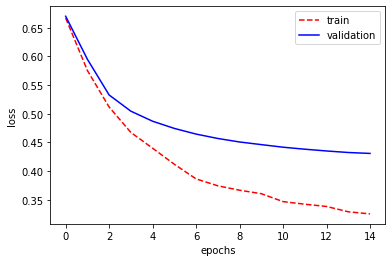

<Figure size 432x288 with 0 Axes>

In [ ]:
from matplotlib import pyplot
from google.colab import files
plt.figure()
plt.plot(np.arange(num_epochs),training_values,'r--')
plt.plot(np.arange(num_epochs),validation_values,'b')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train','validation'])
plt.show()
plt.savefig('pytorch_inception_v3_concatenated_loss_graph.png')
#files.download('pytorch_inception_v3_concatenated_loss_graph.png')

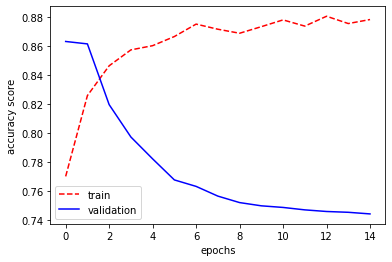

In [ ]:
from matplotlib import pyplot
from google.colab import files
plt.figure()
plt.plot(np.arange(num_epochs),accuracy_train_values,'r--')
plt.plot(np.arange(num_epochs),accuracy_val_values,'b')
plt.ylabel('accuracy score')
plt.xlabel('epochs')
plt.legend(['train','validation'])
plt.show()
# plt.savefig('vishal_pytorch_inception_v3_left&right_f1score_graph.png')

In [ ]:
# print(validation_values,'\n',training_values )

In [ ]:
torch.save(model_conv.state_dict(), 'Rajat_pytorch_VGG_15epoch_nonpretrained_0001lr_BCE_SGD_concatenated_batch32.pt')